# Stereo Camera Calibration

<a href="https://colab.research.google.com/github/ChristianOrr/stereo-camera-calibration/blob/main/stereo_calibration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook shows how to perform a calibration on a stereo camera pair. You will need left and right stereo images of a checkerboard to run this notebook. The stereo images will need to be split and placed in seperate folders for left and right images and the numbering of the pair needs to match. Make sure to follow the "tips for a successful calibration" section below before capturing the images. The calibration will not always go smoothly so make sure to follow the tips in the notebook and learn more about how calibration works. I recommend watching this <a href="https://youtube.com/playlist?list=PL2zRqk16wsdoCCLpou-dGo7QQNks1Ppzo">playlist on camera calibration</a> to understand the theory behind it. 

## Tips for a Successful Calibration

- Good Lighting is important when capturing the checkerboard images. Make sure there is enough light, but also not too much direct light on the board as this may cause reflections.
- Print the checkerboard using a high quality printer from a print shop, dont use a home printer.
- Print on flat and rigid material. The board must not bend while capturing the images.
- Larger boards are better, I recommend using an A1 size.
- Take lots of images. Minimum of 20, but dont got more than 100 as processing time will be bad.
- Capture the board at different angles, rotations and depths from the stereo camera.
- Make sure the cameras are properly focused, so that there is no bluring on the board.
- Dont move the camera of board too quickly while capturing images to minimize motion blur.

### Install All Required Packages Before Starting

If packages are not already installed, set packages_are_installed to False.

In [215]:
packages_are_installed = True # @param {type:"boolean"}
if not packages_are_installed:
    !pip install opencv-contrib-python
    !pip install seaborn
    !pip install pandas
    !pip install matplotlib

In [216]:
import os
import json
from datetime import datetime
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

### Initialise Image Paths and Resolution

Update the paths and image resolution below.

In [217]:
#environment_name = 'gym_mountaincar'  # @param ['dm_cartpole', 'gym_mountaincar']
left_dir = "./stereo_images/left/" # @param {type:"string"}
right_dir = "./stereo_images/right/" # @param {type:"string"}
corners_dir = "./corners" # @param {type:"string"}
calibration_dir = "./calibration_results" # @param {type:"string"}

# make folders for corners detections and calibration results 
os.makedirs(corners_dir, exist_ok=True)
os.makedirs(calibration_dir, exist_ok=True)

# Extract image paths and sort so left and right images match
left_image_names = sorted([name for name in os.listdir(left_dir) if os.path.isfile(f"{left_dir}/{name}")])
right_image_names = sorted([name for name in os.listdir(right_dir) if os.path.isfile(f"{right_dir}/{name}")])

num_images = len(left_image_names) # @param {type: "integer"}
image_width = 640 # @param {type: "integer"}
image_height = 480 # @param {type: "integer"}

### Set Checkerboard Corners for Object Coordinate System  

The corners of the checkerboard only refer to the inner corners of the board. The 3D corners are used to calculate the rotation and translation vectors of corners in the camera coordinate systems left and right cameras with respect to the objects coordinate system (checkerboard coordinate system). 

Make sure to count the number of corner rows and columns.Then update the num_vertical_corners and num_horizontal_corners with the correct values below.

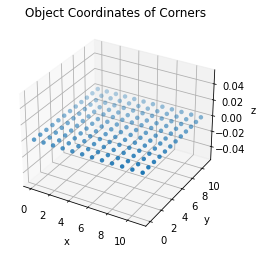

In [218]:
num_vertical_corners = 12 # @params {type: "integer"}
num_horizontal_corners = 12 # @params {type: "integer"}
total_corners = num_vertical_corners * num_horizontal_corners
objp = np.zeros((num_vertical_corners * num_horizontal_corners, 1, 3), np.float32)
objp[:,0, :2] = np.mgrid[0:num_vertical_corners, 0:num_horizontal_corners].T.reshape(-1, 2)
objp = np.array([corner for [corner] in objp])
#Plot
X = objp[:,0]
Y = objp[:,1]
Z = objp[:,2]
ax = plt.axes(projection='3d')
ax.scatter(X, Y, Z, cmap='viridis', edgecolor='none')
ax.set_title("Object Coordinates of Corners")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

### Create a Dataframe for the Calibration Results

In [219]:
calib_dict = {
	"image_id": [i for i in range(1, num_images + 1)],
	"left_image_name": left_image_names,
	"right_image_name": right_image_names,
	"found_chessboard": True, # True or False
	"left_corners": "", # 2d points of chessboard corners in image plane
	"right_corners": "", # 2d points of chessboard corners in image plane
	"object_points": [[objp] for i in range(1, num_images + 1)], # 3d point in real world space (for left and right images)
	"left_rotations": [np.zeros((1, 1, 3), dtype=np.float32) for i in range(1, num_images + 1)], 
	"right_rotations": [np.zeros((1, 1, 3), dtype=np.float32) for i in range(1, num_images + 1)], 
	"left_translations": [np.zeros((1, 1, 3), dtype=np.float32) for i in range(1, num_images + 1)], 
	"right_translations": [np.zeros((1, 1, 3), dtype=np.float32) for i in range(1, num_images + 1)], 
	"left_reprojection_errors": "", # [x, y] error per corner in pixels
	"right_reprojection_errors": "", # [x, y] error per corner in pixels
	"left_error": "", # similar to rms, but per image
	"right_error": "", # similar to rms, but per image
	"left_reprojection_points": "", # [x, y] error per corner in pixels
	"right_reprojection_points": "" # [x, y] error per corner in pixels
}

calib_df = pd.DataFrame(calib_dict)
calib_df = calib_df.set_index("image_id")

## Search for checkerboard Corners

The OpenCV method findChessboardCornersSB is used over the standard findChessboardCorners method since its more accurate. Any image pair with failed corner detections will automatically be removed at the end of searching, so dont be surprised if there are image pairs missing after this phase.

In [220]:
for image_id, row in calib_df.iterrows():
	print ('\nProcessing Left Image: {}, Right Image: {}'.format(row["left_image_name"], row["right_image_name"]))
	left_image = cv2.imread("{}/{}".format(left_dir, row["left_image_name"]), 1)
	left_gray = cv2.cvtColor(left_image, cv2.COLOR_BGR2GRAY)
	right_image = cv2.imread("{}/{}".format(right_dir, row["right_image_name"]), 1)
	right_gray = cv2.cvtColor(right_image, cv2.COLOR_BGR2GRAY)	  
	# Search for corners
	checkerboard_flags = cv2.CALIB_CB_NORMALIZE_IMAGE + cv2.CALIB_CB_EXHAUSTIVE + cv2.CALIB_CB_ACCURACY
	left_retval, left_corners_array = cv2.findChessboardCornersSB(left_gray, (num_vertical_corners, num_horizontal_corners), checkerboard_flags)
	right_retval, right_corners_array = cv2.findChessboardCornersSB(right_gray, (num_vertical_corners, num_horizontal_corners), checkerboard_flags)

	if not (left_retval and right_retval):
		calib_df["found_chessboard"].loc[image_id] = False
		print("Failed to find corners!")
		continue

	left_corners_array = left_corners_array.reshape(-1,2)
	right_corners_array = right_corners_array.reshape(-1,2)

	calib_df["left_corners"].loc[image_id] = left_corners_array
	calib_df["right_corners"].loc[image_id] = right_corners_array
	calib_df["object_points"].loc[image_id] = objp

	# Save detected corners
	left_corners_image = cv2.drawChessboardCorners(left_image, (num_vertical_corners, num_horizontal_corners), left_corners_array, left_retval)
	cv2.imwrite("{}/{}".format(corners_dir, row["left_image_name"]), left_corners_image)
	right_corners_image = cv2.drawChessboardCorners(right_image, (num_vertical_corners, num_horizontal_corners), right_corners_array, right_retval)
	cv2.imwrite("{}/{}".format(corners_dir, row["right_image_name"]), right_corners_image) 

# Remove all images that failed to detect the corners
calib_df.drop(calib_df[(calib_df["found_chessboard"] == False)].index, axis=0, inplace=True)


Processing Left Image: Left1.bmp, Right Image: Right1.bmp


C:\Users\Christian\AppData\Local\Temp\ipykernel_14104\3290015270.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calib_df["found_chessboard"].loc[image_id] = False


Failed to find corners!

Processing Left Image: Left10.bmp, Right Image: Right10.bmp
Failed to find corners!

Processing Left Image: Left11.bmp, Right Image: Right11.bmp

Processing Left Image: Left12.bmp, Right Image: Right12.bmp


C:\Users\Christian\AppData\Local\Temp\ipykernel_14104\3290015270.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calib_df["left_corners"].loc[image_id] = left_corners_array
C:\Users\Christian\AppData\Local\Temp\ipykernel_14104\3290015270.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calib_df["right_corners"].loc[image_id] = right_corners_array
C:\Users\Christian\AppData\Local\Temp\ipykernel_14104\3290015270.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

Failed to find corners!

Processing Left Image: Left13.bmp, Right Image: Right13.bmp

Processing Left Image: Left14.bmp, Right Image: Right14.bmp

Processing Left Image: Left15.bmp, Right Image: Right15.bmp

Processing Left Image: Left2.bmp, Right Image: Right2.bmp
Failed to find corners!

Processing Left Image: Left3.bmp, Right Image: Right3.bmp
Failed to find corners!

Processing Left Image: Left4.bmp, Right Image: Right4.bmp

Processing Left Image: Left5.bmp, Right Image: Right5.bmp

Processing Left Image: Left6.bmp, Right Image: Right6.bmp

Processing Left Image: Left7.bmp, Right Image: Right7.bmp

Processing Left Image: Left8.bmp, Right Image: Right8.bmp
Failed to find corners!

Processing Left Image: Left9.bmp, Right Image: Right9.bmp


### Left and Right Detected Corners

The left image (blue dots) should be on the left side and right image (orange dots) on the right side. 

Note: The rows may not be perfectly inline. This isn't something to be concerned about since it will be solved later with the stereo calibration.

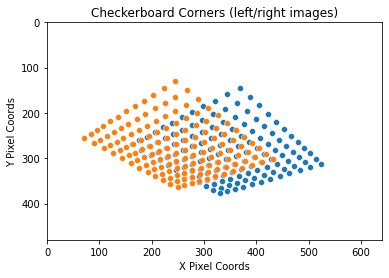

In [221]:
index = 0 # @params {type: "integer"}

left_X = calib_df["left_corners"].iloc[index][:,0]
left_Y = calib_df["left_corners"].iloc[index][:,1]
right_X = calib_df["right_corners"].iloc[index][:,0]
right_Y = calib_df["right_corners"].iloc[index][:,1]

sns.scatterplot(x=left_X, y=left_Y)
sns.scatterplot(x=right_X, y=right_Y)
plt.xlim(0, image_width)
plt.ylim(0, image_height)
plt.gca().invert_yaxis() # Set origin to be the top left
plt.xlabel("X Pixel Coords")
plt.ylabel("Y Pixel Coords")
plt.title("Checkerboard Corners (left/right images)")
plt.show()

## Find Intrinsics

We need to find the intrinsics (pixel focal lengths and principal points) for the left and right cameras. We also need to find the distortion coefficients of the cameras, which will be barrel distortion if a wide angle lenses are used. 

We will use the detected checkerboard points found above together with the known object coordinate system to help us find the intrinsics and distortion.

### Create dictionary to save calibration results

In [222]:
results_dict = {
	"left_camera_matrix": "",
	"right_camera_matrix": "",
	"left_dist": "",
	"right_dist": "",
	"width": image_width,
	"height": image_height,
	"DIM": (image_width, image_height),
	"left_rms": "",
	"right_rms": "",	
	"left_map_x_undistort": "", 
	"left_map_y_undistort": "",
	"right_map_x_undistort": "", 
	"right_map_y_undistort": "",
	"left_right_flags": cv2.CALIB_ZERO_TANGENT_DIST,
	"left_right_criteria": (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-6),
	# Stereo values
	"stereo_rms": "",
	"R": "", 
	"T": "",
	"stereo_flags": cv2.CALIB_FIX_INTRINSIC + cv2.CALIB_ZERO_TANGENT_DIST,
	"stereo_criteria": (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 30, 0.1),
	"left_RT": "", 
	"right_RT": "", 
	"left_P": "", 
	"right_P": "", 
	"Q": "",
	"left_map_x_rectify": "", 
	"left_map_y_rectify": "",
	"right_map_x_rectify": "", 
	"right_map_y_rectify": "",
}

### Find Left Intrinsic Matrix and Distortion Coefficients

A good calibration will have an RMS below 0.4 and the left camera reprojection error plot should show a circular cluster centered around 0.

C:\Users\Christian\AppData\Local\Temp\ipykernel_14104\515160519.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calib_df["left_rotations"].loc[list(calib_df.index)] = left_rotations
C:\Users\Christian\AppData\Local\Temp\ipykernel_14104\515160519.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calib_df["left_translations"].loc[list(calib_df.index)] = left_translations
C:\Users\Christian\AppData\Local\Temp\ipykernel_14104\515160519.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/


Left Camera RMS: 0.3071902951475677

Left Camera Matrix: 
[[558.82535971   0.         327.12831072]
 [  0.         559.69239251 252.55647119]
 [  0.           0.           1.        ]]

Left Distortion Coefficients: 
[[-0.30849339]
 [ 0.60436537]
 [ 0.        ]
 [ 0.        ]
 [-0.67844972]]



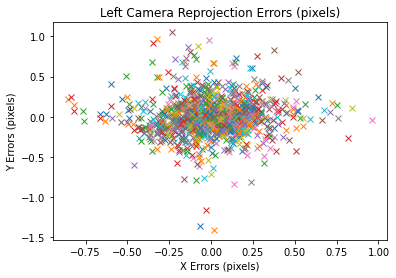

In [223]:
def calibrate_left(calib_df, results_dict):
	results_dict["left_rms"], results_dict["left_camera_matrix"], results_dict["left_dist"], left_rotations, left_translations = cv2.calibrateCamera(
		objectPoints = calib_df["object_points"].to_numpy(), 
		imagePoints = calib_df["left_corners"].to_numpy(), 
		imageSize = results_dict["DIM"],
		cameraMatrix = np.zeros((3, 3)),
		distCoeffs = np.zeros((4, 1)),
		rvecs = calib_df["left_rotations"].to_numpy(),
		tvecs = calib_df["left_translations"].to_numpy(),
		flags = results_dict["left_right_flags"]
		)


	# Update df with the calibration results
	calib_df["left_rotations"].loc[list(calib_df.index)] = left_rotations
	calib_df["left_translations"].loc[list(calib_df.index)] = left_translations

	# Display Calibration Performance
	print("\nLeft Camera RMS: {}".format(results_dict["left_rms"]))
	print("\nLeft Camera Matrix: \n{}".format(results_dict["left_camera_matrix"] ))
	print("\nLeft Distortion Coefficients: \n{}\n".format(results_dict["left_dist"]))

	# Reprojection error
	for image_id, row in calib_df.iterrows():
		left_reprojected_points, _ = cv2.projectPoints(
			objectPoints = row["object_points"], 
			rvec = row["left_rotations"], 
			tvec = row["left_translations"], 
			cameraMatrix = results_dict["left_camera_matrix"] , 
			distCoeffs = results_dict["left_dist"]
			)
		# Add reprojection errors and points to the dataframe
		left_reprojected_points = left_reprojected_points.reshape(-1,2)
		calib_df["left_reprojection_errors"].loc[image_id] = row["left_corners"] - left_reprojected_points
		calib_df["left_reprojection_points"].loc[image_id] = left_reprojected_points
		# find error similar to rms per image
		calib_df["left_error"].loc[image_id] = np.sqrt(np.sum(np.square(row["left_corners"] - left_reprojected_points)) / total_corners)

	# Plot the reprojection errors
	left_errors = np.stack(calib_df["left_reprojection_errors"].to_numpy())
	plt.plot(left_errors[:, :, 0], left_errors[:, :, 1], "x")
	plt.title("Left Camera Reprojection Errors (pixels)")
	plt.xlabel("X Errors (pixels)")
	plt.ylabel("Y Errors (pixels)")
	plt.show()
	return calib_df, results_dict
calib_df, results_dict = calibrate_left(calib_df, results_dict)

### Find Right Intrinsic Matrix and Distortion Coefficients

The metrics for a good calibration are the same as the left image. The RMS should be below 0.4 and the left camera reprojection error plot should show a circular cluster centered around 0.

C:\Users\Christian\AppData\Local\Temp\ipykernel_14104\995839718.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calib_df["right_rotations"].loc[list(calib_df.index)] = right_rotations
C:\Users\Christian\AppData\Local\Temp\ipykernel_14104\995839718.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calib_df["right_translations"].loc[list(calib_df.index)] = right_translations
C:\Users\Christian\AppData\Local\Temp\ipykernel_14104\995839718.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta


Right Camera RMS: 0.3186082915398479

Right Camera Matrix: 
[[559.10000997   0.         304.80355251]
 [  0.         559.56813129 243.7322747 ]
 [  0.           0.           1.        ]]

Right Distortion Coefficients: 
[[-0.27473316]
 [ 0.3238439 ]
 [ 0.        ]
 [ 0.        ]
 [ 0.23604821]]



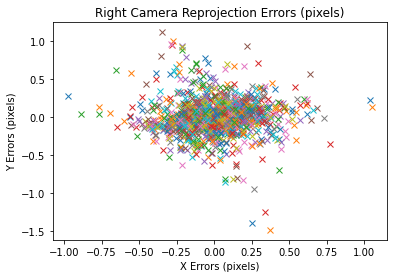

In [224]:
def calibrate_right(calib_df, results_dict):
	results_dict["right_rms"], results_dict["right_camera_matrix"], results_dict["right_dist"], right_rotations, right_translations = cv2.calibrateCamera(
		objectPoints = calib_df["object_points"].to_numpy(), 
		imagePoints = calib_df["right_corners"].to_numpy(), 
		imageSize = results_dict["DIM"],
		cameraMatrix = np.zeros((3, 3)),
		distCoeffs = np.zeros((4, 1)),
		rvecs = calib_df["right_rotations"].to_numpy(),
		tvecs = calib_df["right_translations"].to_numpy(),
		flags = results_dict["left_right_flags"]
		)

	# Update all rows with the calibration values
	calib_df["right_rotations"].loc[list(calib_df.index)] = right_rotations
	calib_df["right_translations"].loc[list(calib_df.index)] = right_translations

	# Display Calibration Results
	print("\nRight Camera RMS: {}".format(results_dict["right_rms"]))
	print("\nRight Camera Matrix: \n{}".format(results_dict["right_camera_matrix"]))
	print("\nRight Distortion Coefficients: \n{}\n".format(results_dict["right_dist"]))

	# Reprojection error
	for image_id, row in calib_df.iterrows():
		right_reprojected_points, _ = cv2.projectPoints(
			objectPoints = row["object_points"], 
			rvec = row["right_rotations"], 
			tvec = row["right_translations"], 
			cameraMatrix = results_dict["right_camera_matrix"], 
			distCoeffs = results_dict["right_dist"]
			)
		# Add reprojection errors and points to the dataframe
		right_reprojected_points = right_reprojected_points.reshape(-1,2)
		calib_df["right_reprojection_errors"].loc[image_id] = row["right_corners"] - right_reprojected_points
		calib_df["right_reprojection_points"].loc[image_id] = right_reprojected_points
		# find error similar to rms per image
		calib_df["right_error"].loc[image_id] = np.sqrt(np.sum(np.square(row["right_corners"] - right_reprojected_points)) / total_corners)

	# Plot the reprojection errors
	right_errors = np.stack(calib_df["right_reprojection_errors"].to_numpy())
	plt.plot(right_errors[:, :, 0], right_errors[:, :, 1], "x")
	plt.title("Right Camera Reprojection Errors (pixels)")
	plt.xlabel("X Errors (pixels)")
	plt.ylabel("Y Errors (pixels)")
	plt.show()
	return calib_df, results_dict
calib_df, results_dict = calibrate_right(calib_df, results_dict)

### Plot Left and Right RMS Errors for Image Pairs

The plot below helps us easily identify the pair of images with poor corner reprojection performance. The worst performing pair of images will be in the top right and best performing on the bottom left. Each cross represents an image pair with the number next to it representing the pairs ID.

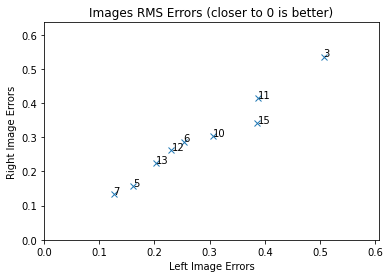

In [225]:
def plot_left_right_errors(calib_df):
    # Mean of left and right errors
	calib_df["mean_errors"] = calib_df.apply(lambda row: (row["left_error"] + row["right_error"]) / 2, axis=1)

	# Display calibration performance per image
	plt.plot(calib_df["left_error"].to_numpy(), calib_df["right_error"].to_numpy(), "x")
	plt.title("Images RMS Errors (closer to 0 is better)")
	plt.xlabel("Left Image Errors")
	plt.ylabel("Right Image Errors")
	plt.xlim([0, calib_df["left_error"].max() + 0.1])
	plt.ylim([0, calib_df["right_error"].max() + 0.1])
	# Add image numbers to the points
	[plt.annotate(index, (row["left_error"], row["right_error"])) for index, row in calib_df.iterrows()]
	plt.show()
plot_left_right_errors(calib_df)

Below is the ID's for each image pair for reference

In [226]:
calib_df[["left_image_name", "right_image_name"]]

,left_image_name,right_image_name
image_id,,
3,Left11.bmp,Right11.bmp
5,Left13.bmp,Right13.bmp
6,Left14.bmp,Right14.bmp
7,Left15.bmp,Right15.bmp
10,Left4.bmp,Right4.bmp
11,Left5.bmp,Right5.bmp
12,Left6.bmp,Right6.bmp
13,Left7.bmp,Right7.bmp
15,Left9.bmp,Right9.bmp


### Plot reprojected over detected corners

If calibration is successful, then none of the detected corners (blue dots) should be visible. This validates that the calibration was successful.

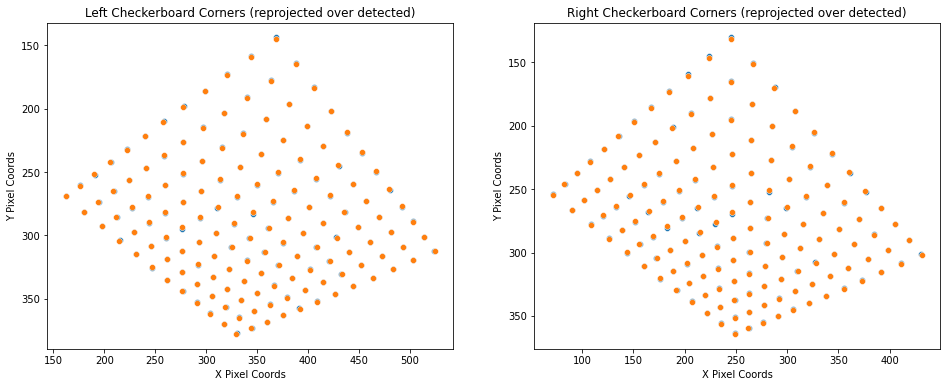

In [227]:
index = 0 # Select the image to display

left_X = calib_df["left_corners"].iloc[index][:,0]
left_Y = calib_df["left_corners"].iloc[index][:,1]
lproj_X = calib_df["left_reprojection_points"].iloc[index][:,0] 
lproj_Y = calib_df["left_reprojection_points"].iloc[index][:,1]

right_X = calib_df["right_corners"].iloc[index][:,0]
right_Y = calib_df["right_corners"].iloc[index][:,1]
rproj_X = calib_df["right_reprojection_points"].iloc[index][:,0] 
rproj_Y = calib_df["right_reprojection_points"].iloc[index][:,1]

fig = plt.figure(figsize=(16,6))
ax1, ax2 = fig.subplots(1,2)

sns.scatterplot(x=left_X, y=left_Y, ax=ax1)
sns.scatterplot(x=lproj_X, y=lproj_Y, ax=ax1)
sns.scatterplot(x=right_X, y=right_Y, ax=ax2)
sns.scatterplot(x=rproj_X, y=rproj_Y, ax=ax2)

ax1.invert_yaxis() # Set origin to be the top left
ax2.invert_yaxis() # Set origin to be the top left
ax1.set_xlabel("X Pixel Coords")
ax1.set_ylabel("Y Pixel Coords")
ax2.set_xlabel("X Pixel Coords")
ax2.set_ylabel("Y Pixel Coords")

ax1.set_title("Left Checkerboard Corners (reprojected over detected)")
ax2.set_title("Right Checkerboard Corners (reprojected over detected)")
plt.show()

### Remove Worst Images and Recalibrate if Necessary

If the calibration did not perform well, then remove the highest RMS images and recalibrate. 
You can tell if the calibration was poor if for example the blue dots are not fully covered by the orange dots in the reprojected over detected images above. 
Another sign of poor performance is if the RMS is high. 0.4 or greater RMS is a high value.

Its generally better to have more images, but if there is a large batch of bad images then you can remove more images by decreasing keep_best_ratio.


Left recalibration

Left Camera RMS: 0.2102725407117396

Left Camera Matrix: 
[[565.82225947   0.         331.15571074]
 [  0.         566.83706914 253.15623423]
 [  0.           0.           1.        ]]

Left Distortion Coefficients: 
[[-0.29892228]
 [ 0.63112242]
 [ 0.        ]
 [ 0.        ]
 [-0.74235406]]



C:\Users\Christian\AppData\Local\Temp\ipykernel_14104\515160519.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calib_df["left_rotations"].loc[list(calib_df.index)] = left_rotations
C:\Users\Christian\AppData\Local\Temp\ipykernel_14104\515160519.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calib_df["left_translations"].loc[list(calib_df.index)] = left_translations
C:\Users\Christian\AppData\Local\Temp\ipykernel_14104\515160519.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

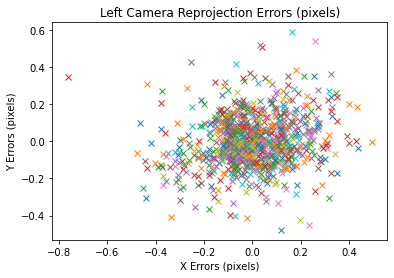


Right recalibration

Right Camera RMS: 0.22489058467517153

Right Camera Matrix: 
[[562.23216803   0.         312.00644847]
 [  0.         561.83047353 244.58265121]
 [  0.           0.           1.        ]]

Right Distortion Coefficients: 
[[-0.27749644]
 [ 0.44352986]
 [ 0.        ]
 [ 0.        ]
 [-0.01556326]]



C:\Users\Christian\AppData\Local\Temp\ipykernel_14104\995839718.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calib_df["right_rotations"].loc[list(calib_df.index)] = right_rotations
C:\Users\Christian\AppData\Local\Temp\ipykernel_14104\995839718.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calib_df["right_translations"].loc[list(calib_df.index)] = right_translations
C:\Users\Christian\AppData\Local\Temp\ipykernel_14104\995839718.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

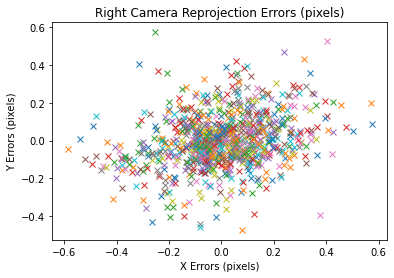


Images RMS Performance


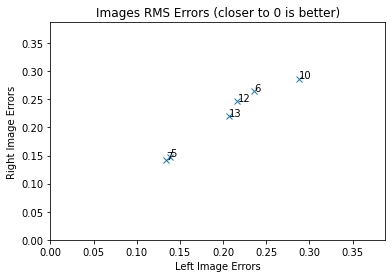

In [228]:
recalibrate = True # @param {type:"boolean"}
# Keep the images with top rms performace (lower ratio means fewer images)
keep_best_ratio = 0.7 # @param {type:"slider", min:0, max:1, step:0.01} 

if recalibrate:
    # Find and drop images with the worst performance
    mean_errors = calib_df["mean_errors"]
    mean_errors = mean_errors.sort_values()

    # select worst images to remove
    images_to_drop = list(mean_errors.iloc[int(len(mean_errors) * keep_best_ratio):].index)
    # Remove poor performing images
    calib_df.drop(images_to_drop, axis=0, inplace=True)
    print("\nLeft recalibration")
    calib_df, results_dict = calibrate_left(calib_df, results_dict)
    print("\nRight recalibration")
    calib_df, results_dict = calibrate_right(calib_df, results_dict)
    print("\nImages RMS Performance")
    plot_left_right_errors(calib_df)

## Find Extrinsics

Now that the intrinsics and distortion coefficients have been calculated for the left and right cameras, we can calculate the extrinsics for the camera coordinate systems with respect to each other.

### Rotation and Translation of Camera Coordinate Systems

Find the rotation, R and translation T of the left camera coordinate system with respect to the right camera coordinate system.

In [229]:
results_dict["stereo_rms"], _, _, _, _, results_dict["R"], results_dict["T"], E, F = cv2.stereoCalibrate(
	objectPoints = calib_df["object_points"].to_numpy(), 
	imagePoints1 = calib_df["left_corners"].to_numpy(), 
	imagePoints2 = calib_df["right_corners"].to_numpy(), 
	cameraMatrix1 = results_dict["left_camera_matrix"], 
	distCoeffs1 = results_dict["left_dist"], 
	cameraMatrix2 = results_dict["right_camera_matrix"], 
	distCoeffs2 = results_dict["right_dist"], 
	imageSize = results_dict["DIM"], 
	R = None, 
	T = None,
	flags = results_dict["stereo_flags"], 
	criteria = results_dict["stereo_criteria"]
	)

print ("Stereo RMS: ", results_dict["stereo_rms"])

Stereo RMS:  0.25118723199377235


### Left and Right Rectification Transforms and Projection Matrices

Find the left rectification transform, left_RT which is used to transform the points in the unrectified left cameras coordinate system to the rectified left camera coordinate system. Similarly the right rectification transform, right_RT is used to transform the points in the unrectified right cameras coordinate system to the rectified right camera coordinate system.

The left projection matrix is used to project points in the rectified left camera coordinate system (obtained using left_RT) to the rectified left camera's image. Similarly the right projection matrix is used to project points in the rectified right camera coordinate system (obtained using right_RT) to the rectified right camera's image.

In [230]:
(results_dict["left_RT"], results_dict["right_RT"], results_dict["left_P"], results_dict["right_P"], results_dict["Q"], validPixROI1, validPixROI2) = cv2.stereoRectify(
	cameraMatrix1 = results_dict["left_camera_matrix"], 
	distCoeffs1 = results_dict["left_dist"], 
	cameraMatrix2 = results_dict["right_camera_matrix"], 
	distCoeffs2 = results_dict["right_dist"], 
	imageSize = results_dict["DIM"], 
	R = results_dict["R"], 
	T = results_dict["T"]
	)

## Save Results for Reuse

Now that all the necessary calibration information has been extracted the results can be saved for reuse. These calibration results will be valid as long as the stereo camera's position with respect to eachother doesnt move and the cameras sensors or lenses dont get changed. In the case that any of these changes are made the calibration will need to be performed again. 

The stereo images can now be rectified and used for disparity estimation using stereo matching techniques.

### Undistortion Maps

The left and right maps below can be used for removing distortion from the images. The maps are built for the inverse mapping algorithm used by the OpenCV remap function to translate the pixel coordinates into the correct undistorted position. The x maps translates the pixels in the x direction and the y map translates the pixels in the y direction.

Note: These maps are not needed for disparity estimation, since they don't rectify the left and right images with respect to each other. See below for the rectification maps.

In [231]:

results_dict["left_map_x_undistort"], results_dict["left_map_y_undistort"] = cv2.initUndistortRectifyMap(
	cameraMatrix = results_dict["left_camera_matrix"], 
	distCoeffs = results_dict["left_dist"], 
	R = None, 
	newCameraMatrix = None, 
	size = results_dict["DIM"], 
	m1type = cv2.CV_16SC2)
results_dict["right_map_x_undistort"], results_dict["right_map_y_undistort"] = cv2.initUndistortRectifyMap(
	cameraMatrix = results_dict["right_camera_matrix"], 
	distCoeffs = results_dict["right_dist"], 
	R = None, 
	newCameraMatrix = None, 
	size = results_dict["DIM"], 
	m1type = cv2.CV_16SC2)

np.savez(
	"{}/calibration_left.npz".format(calibration_dir),
	left_map = results_dict["left_map_x_undistort"], 
	right_map = results_dict["left_map_y_undistort"], 
	objpoints = calib_df["object_points"].to_numpy(), 
	imgpoints = calib_df["left_corners"].to_numpy(),
	camera_matrix = results_dict["left_camera_matrix"], 
	distortion_coeff = results_dict["left_dist"], 
	imageSize = results_dict["DIM"]
	)
np.savez(
	"{}/calibration_right.npz".format(calibration_dir),
	left_map = results_dict["right_map_x_undistort"], 
	right_map = results_dict["right_map_y_undistort"], 
	objpoints = calib_df["object_points"].to_numpy(), 
	imgpoints = calib_df["right_corners"].to_numpy(),
	camera_matrix = results_dict["right_camera_matrix"], 
	distortion_coeff = results_dict["right_dist"], 
	imageSize = results_dict["DIM"]
	)

### Rectification Maps

The maps below can be used to undistort and rectify the stereo images. The maps are built for the inverse mapping algorithm used by the OpenCV remap function to translate the pixel coordinates into the correct rectified position. The x maps translates the pixels in the x direction and the y map translates the pixels in the y direction.

In [232]:
results_dict["left_map_x_rectify"], results_dict["left_map_y_rectify"] = cv2.initUndistortRectifyMap(
	cameraMatrix = results_dict["left_camera_matrix"], 
	distCoeffs = results_dict["left_dist"], 
	R = results_dict["left_RT"], 
	newCameraMatrix = results_dict["left_P"], 
	size = results_dict["DIM"], 
	m1type = cv2.CV_16SC2 
	)
results_dict["right_map_x_rectify"], results_dict["right_map_y_rectify"] = cv2.initUndistortRectifyMap(
	cameraMatrix = results_dict["right_camera_matrix"], 
	distCoeffs = results_dict["right_dist"], 
	R = results_dict["right_RT"], 
	newCameraMatrix = results_dict["right_P"], 
	size = results_dict["DIM"], 
	m1type = cv2.CV_16SC2 
)

np.savez_compressed(
	calibration_dir + "/stereo_calibration.npz", 
	imageSize = results_dict["DIM"],
	left_map_x_rectify = results_dict["left_map_x_rectify"], 
	left_map_y_rectify = results_dict["left_map_y_rectify"],
	right_map_x_rectify = results_dict["right_map_x_rectify"], 
	right_map_y_rectify = results_dict["right_map_y_rectify"], 
	disparityToDepthMap = results_dict["Q"],
	rotationMatrix = results_dict["R"], 
	translationVector = results_dict["T"]
	)

results_output_dict = {
	"left_camera_matrix": results_dict["left_camera_matrix"].tolist(),
	"right_camera_matrix": results_dict["right_camera_matrix"].tolist(),
	"left_dist": results_dict["left_dist"].tolist(),
	"right_dist": results_dict["right_dist"].tolist(),
	"width": results_dict["width"],
	"height": results_dict["height"],
	"DIM": results_dict["DIM"],
	"left_rms": results_dict["left_rms"],
	"right_rms": results_dict["right_rms"],	
	"left_right_flags": results_dict["left_right_flags"],
	"left_right_criteria": results_dict["left_right_criteria"],
	# Stereo values
	"stereo_rms": results_dict["stereo_rms"],
	"R": results_dict["R"].tolist(), 
	"T": results_dict["T"].tolist(),
	"stereo_flags": results_dict["stereo_flags"],
	"stereo_criteria": results_dict["stereo_criteria"],
	"left_RT": results_dict["left_RT"].tolist(), 
	"right_RT": results_dict["right_RT"].tolist(), 
	"left_P": results_dict["left_P"].tolist(), 
	"right_P": results_dict["right_P"].tolist(), 
	"Q": results_dict["Q"].tolist(),
	"calibration_time": datetime.now().strftime("%d/%m/%Y %H:%M:%S"),
}

results_path = "{}/calibration_results.json".format(calibration_dir)
with open(results_path, "w") as file:
	json.dump(results_output_dict, file, indent=4, sort_keys=False)

## Display Undistorted and Rectified Images

Now its time to see undistortion and rectification on images.

### Load the Maps

Note: You can also directly use the maps obtained above. The maps are loaded mainly for demonstration.

In [233]:
left_npzfile = np.load("{}/calibration_left.npz".format(calibration_dir))
right_npzfile = np.load("{}/calibration_right.npz".format(calibration_dir))
stereo_npzfile = np.load("{}/stereo_calibration.npz".format(calibration_dir))
   
# undistortion maps
left_map_x_undistort = left_npzfile["left_map"]
right_map_x_undistort = right_npzfile["left_map"]
left_map_y_undistort = left_npzfile["right_map"]
right_map_y_undistort = right_npzfile["right_map"]
# rectification maps
left_map_x_rectify = stereo_npzfile["left_map_x_rectify"]
left_map_y_rectify = stereo_npzfile["left_map_y_rectify"]
right_map_x_rectify = stereo_npzfile["right_map_x_rectify"]
right_map_y_rectify = stereo_npzfile["right_map_y_rectify"]

### Select the Image Pair to Test

In [234]:
index = 1 # @param {type: "integer"}

resized_width = 1280 # @param {type: "integer"}
resized_height = 480 # @param {type: "integer"}
# Load images
left_image = cv2.imread("{}/{}".format(left_dir, calib_df["left_image_name"].iloc[index]), 1)
right_image = cv2.imread("{}/{}".format(right_dir, calib_df["right_image_name"].iloc[index]), 1)

### Display the Raw Right and Left Images

The left image is on the left and right image on the right. Four black lines have been added to the pair to compare points in the left and right images.

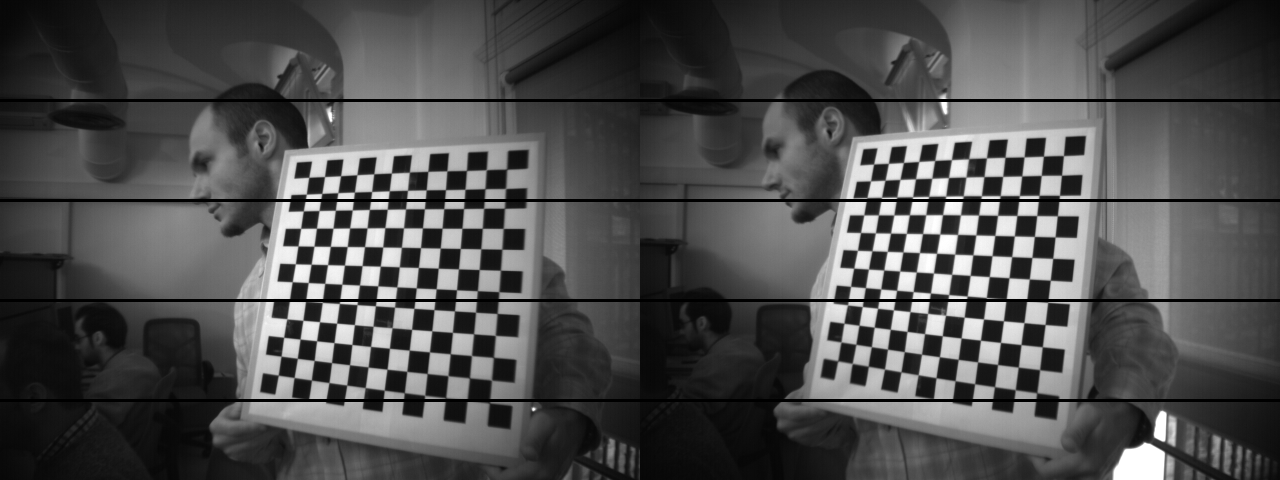

In [235]:
joined = np.concatenate([left_image, right_image], axis=1)
joined_small = cv2.resize(joined, (resized_width, resized_height), interpolation = cv2.INTER_AREA)
# Draw horizontal lines
cv2.line(joined_small, (0, 100), (resized_width, 100), (0,0,0), 2)
cv2.line(joined_small, (0, 200), (resized_width, 200), (0,0,0), 2)
cv2.line(joined_small, (0, 300), (resized_width, 300), (0,0,0), 2)
cv2.line(joined_small, (0, 400), (resized_width, 400), (0,0,0), 2)

joined_small = cv2.cvtColor(joined_small, cv2.COLOR_BGR2RGB)
display(Image.fromarray(joined_small))

### Undistort Stereo Pair

If the lenses are wide angle the undistorted pair below will have a significant change to the raw images above. In this case the lenses have minimal distortion, so there isn't a huge difference.

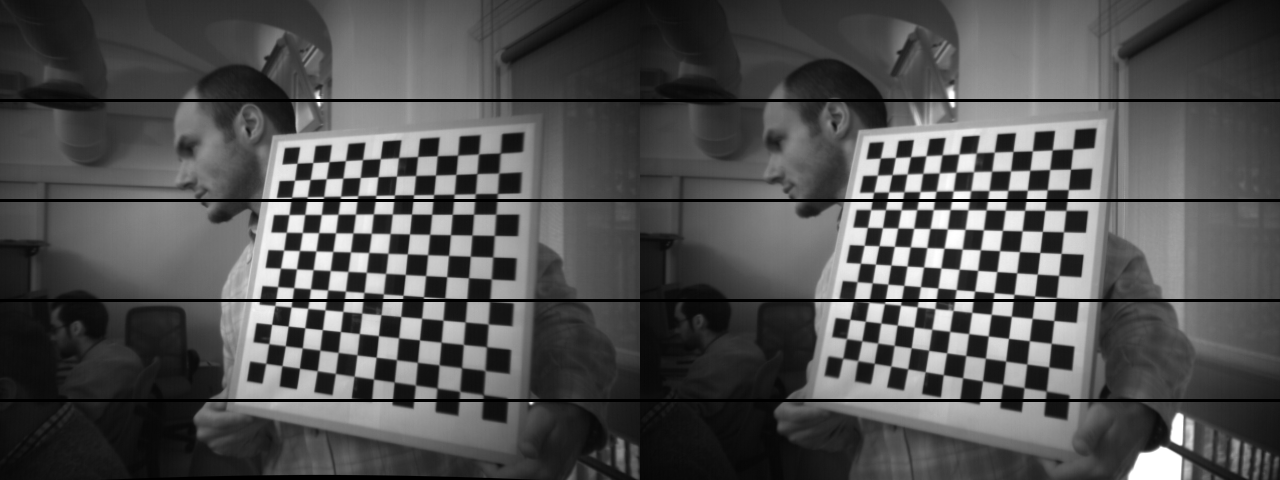

In [236]:
undistorted_left = cv2.remap(left_image, left_map_x_undistort, left_map_y_undistort, interpolation=cv2.INTER_LINEAR)
undistorted_right = cv2.remap(right_image, right_map_x_undistort, right_map_y_undistort, interpolation=cv2.INTER_LINEAR)
joined_undistort = np.concatenate([undistorted_left, undistorted_right], axis=1)
joined_undistorted_small = cv2.resize(joined_undistort, (resized_width, resized_height), interpolation = cv2.INTER_AREA)
# Draw horizontal lines
cv2.line(joined_undistorted_small, (0, 100), (resized_width, 100), (0,0,0), 2)
cv2.line(joined_undistorted_small, (0, 200), (resized_width, 200), (0,0,0), 2)
cv2.line(joined_undistorted_small, (0, 300), (resized_width, 300), (0,0,0), 2)
cv2.line(joined_undistorted_small, (0, 400), (resized_width, 400), (0,0,0), 2)

joined_undistorted_small = cv2.cvtColor(joined_undistorted_small, cv2.COLOR_BGR2RGB)
display(Image.fromarray(joined_undistorted_small))

### Rectify Stereo Pair

The stereo pair below should now have the horizontal lines alligned on the same objects in the left and right images. If the images are not horzontally alligned, then the calibration failed and some improvements will need to be made to the checkerboard capturing technique. See the "tips for a successful calibration" section at the top of the notebook. 

Note: The checkerboard images used for this calibration are very dark and out of focus, hence why the calibration was not the best. There were 15 pairs and corners could not be found on all of them. For reference the dataset was obtained from <a href="http://vision.deis.unibo.it/~smatt/stereo/Calibration.html">here</a>. I will swap these out with a better dataset later. 

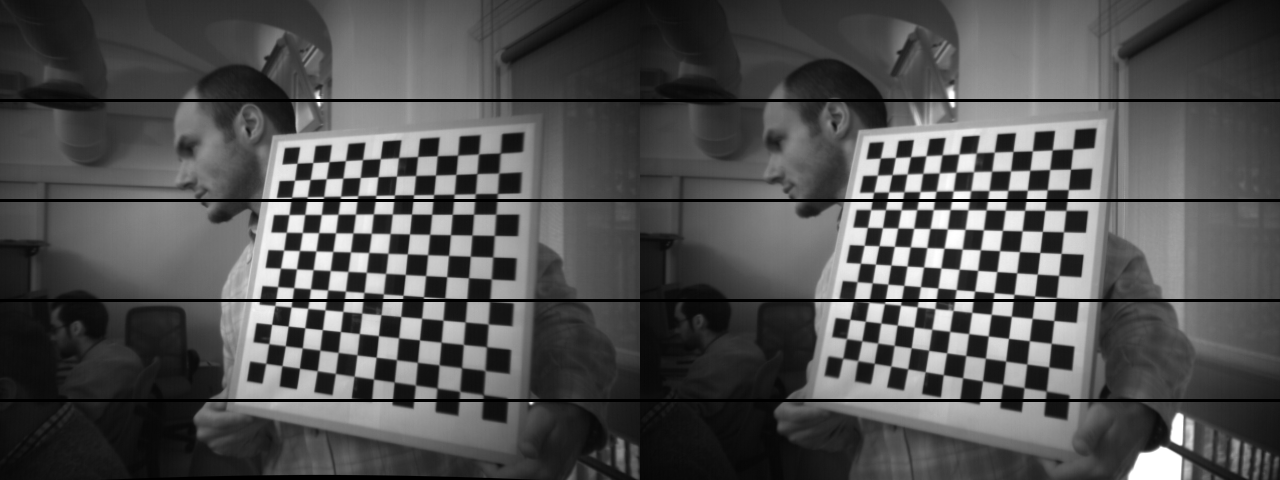

In [237]:
rect_left = cv2.remap(left_image, left_map_x_rectify, left_map_y_rectify, interpolation=cv2.INTER_LINEAR)
rect_right = cv2.remap(right_image, right_map_x_rectify, right_map_y_rectify, interpolation=cv2.INTER_LINEAR)
joined_rect = np.concatenate([rect_left, rect_right], axis=1)
joined_rect_small = cv2.resize(joined_rect, (resized_width, resized_height), interpolation = cv2.INTER_AREA)
# Draw horizontal lines
cv2.line(joined_rect_small, (0, 100), (resized_width, 100), (0,0,0), 2)
cv2.line(joined_rect_small, (0, 200), (resized_width, 200), (0,0,0), 2)
cv2.line(joined_rect_small, (0, 300), (resized_width, 300), (0,0,0), 2)
cv2.line(joined_rect_small, (0, 400), (resized_width, 400), (0,0,0), 2)

joined_rect_small = cv2.cvtColor(joined_undistorted_small, cv2.COLOR_BGR2RGB)
display(Image.fromarray(joined_rect_small))

## Calibration was Successful, What's Next?

Now that you have a calibrated stereo camera, you may apply your favourite stereo depth estimation technique to estimate depth from the rectified stereo pair. You can try OpenCV's block matching techniques. They are a good place to start but are limited in their capability. After trying block matching you may want to try more advanced methods, such as deep stereo methods like
<a href="https://github.com/ChristianOrr/madnet-deep-stereo-with-keras">MADNet</a>.